In [1]:
%pip install agentpy 

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Model Design
import agentpy as ap 
import numpy as np 
import pandas as pd
from boids_model import BoidsModel

# Visualisation
from visualisation import animation_plot, animation_plot_single
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split


In [3]:
results = ap.DataDict.load('BoidsModel')

Loading from directory ap_output/BoidsModel_1/
Loading parameters_sample.csv - Successful
Loading parameters_constants.json - Successful
Loading reporters.csv - Successful
Loading info.json - Successful
Loading variables_BoidsModel.csv - Successful
Loading parameters_log.json - Successful


In [32]:
X =  results.reporters[['cohesion_strength', 'seperation_strength', 'alignment_strength', 'border_strength']]
Y = results.reporters[['final_alignment', 'final_cohesion', 'final_separation_avg', 'final_border_distance_avg']]

In [33]:
# Split the data into training+validation set and test set
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Split the training+validation set into separate training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)

# Convert the datasets to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
Y_train = torch.tensor(Y_train.values, dtype=torch.float32)
X_val = torch.tensor(X_val.values, dtype=torch.float32)
Y_val = torch.tensor(Y_val.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
Y_test = torch.tensor(Y_test.values, dtype=torch.float32)

In [38]:
# Neural Network Architecture
class Net(nn.Module):
    def __init__(self, X, Y):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X.size(1), 128)  # Input layer to 128 neurons
        self.fc2 = nn.Linear(128, 64)         # Hidden layer (128 to 64 neurons)
        self.fc3 = nn.Linear(64, 32)   # Hidden layer (64 to 32 neurons)
        self.fc4 = nn.Linear(32, Y.size(1))   # Output layer (32 to number of target features)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # No activation function in the output layer
        return x

In [39]:
model = Net(X_train, Y_train)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(1000):  # Number of epochs
    optimizer.zero_grad()   # Zero the gradient buffers
    output = model(X_train)         # Pass the batch through the network
    loss = criterion(output, Y_train)  # Compute the loss
    loss.backward()         # Backpropagation
    optimizer.step()        # Update weights

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate the model with test data (if available)

Epoch 1, Loss: 171.35850524902344
Epoch 101, Loss: 10.453859329223633
Epoch 201, Loss: 7.619934558868408
Epoch 301, Loss: 6.002691745758057
Epoch 401, Loss: 4.470196723937988
Epoch 501, Loss: 2.9074478149414062
Epoch 601, Loss: 2.1980466842651367
Epoch 701, Loss: 1.750746726989746
Epoch 801, Loss: 1.4666692018508911
Epoch 901, Loss: 1.2895525693893433


In [40]:
# Assuming 'model' is your trained model and 'loss_fn' is your loss function
model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Do not calculate gradients to save memory
    # Calculate the predictions for the test set
    Y_pred = model(X_test)

    # Calculate the loss for the test set
    test_loss = criterion(Y_pred, Y_test)

print(f'Test loss: {test_loss.item()}')

Test loss: 2.1824073791503906


In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate the predictions for the test set
Y_pred = model(X_test)

# Convert the predictions and true values to NumPy arrays
Y_pred_np = Y_pred.detach().numpy()
Y_test_np = Y_test.numpy()

# Calculate the metrics
mae = mean_absolute_error(Y_test_np, Y_pred_np)
mse = mean_squared_error(Y_test_np, Y_pred_np)
r2 = r2_score(Y_test_np, Y_pred_np)

print(f'MAE: {mae}, MSE: {mse}, R^2: {r2}')

MAE: 0.9371826648712158, MSE: 2.1824073791503906, R^2: 0.6308080139250469


/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Mat

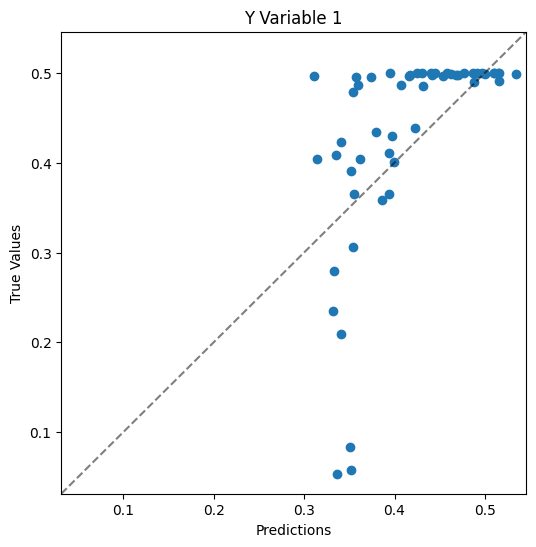

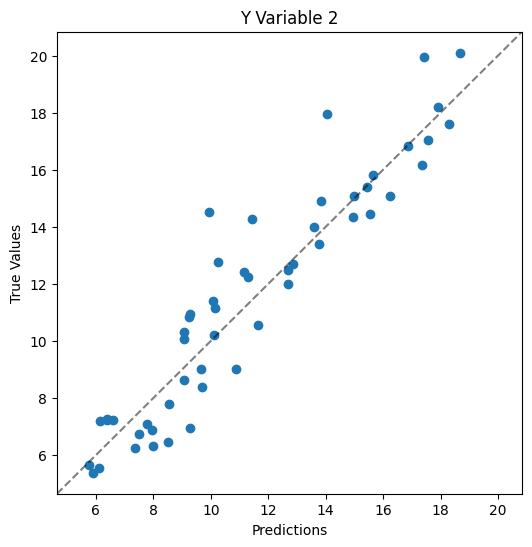

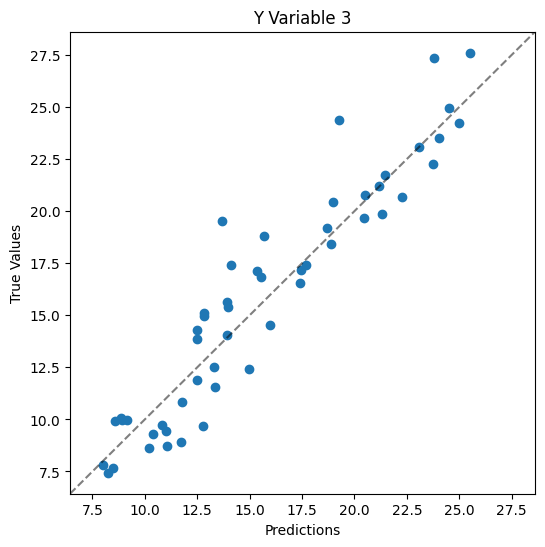

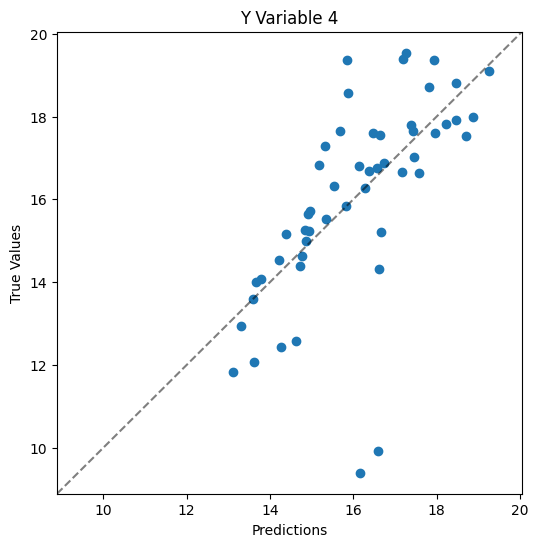

In [42]:
import matplotlib.pyplot as plt

# Assuming Y_test_np and Y_pred_np are 2D arrays with 4 columns each
for i in range(4):
    plt.figure(figsize=(6, 6))
    plt.scatter(Y_pred_np[:, i], Y_test_np[:, i])
    plt.xlabel('Predictions')
    plt.ylabel('True Values')
    plt.title(f'Y Variable {i+1}')

    # Add a diagonal line
    limits = [np.min([plt.xlim(), plt.ylim()]),  # Find the lower limit
              np.max([plt.xlim(), plt.ylim()])]  # Find the upper limit
    plt.xlim(limits)
    plt.ylim(limits)
    plt.plot(limits, limits, color='black', alpha=0.5, linestyle='--')

    plt.show()